## Ising Model

Consider a 2 dimensional squared lattice (NxN) where every cell is occupied by a particle. Every particle can take two possible values of spin $\sigma$, +1 or -1. These particles only **interact** with their **nearest neighbours** (NN) so, the total interaction energy of the system in a spin configuration 'S' is

$$  E(S) = -\frac{1}{2}\sum_{i = 1}^{N}\sum_{j = 1}^{N}s(i, j)[s(i, j+1)+s(i, j-1)+s(i+1, j)+s(i-1, j)] \tag{1}$$

where $s(i,j)$ is the spin state (+1 or -1) of the cell (i,j). We will assume **periodic boundary conditions**, that is, s(0,j) = s(N,j), s(N+1, j) = s(1, j), s(i, 0) = s(i, N) and s(i, N+1) = s(i, 1).

From statistical mechanics (of equilibrium) we know that the probability, $P$,  of finding the system in a state $S$ is

$$ P(S)=\frac{1}{Z} e^{-\beta E(S)} \tag{2}$$
 
where $\beta=1 /\left(k_{B} T\right)$, $k_{B}$ the Boltzmann constant and $Z$ is the partition function.

In order to find the time evolution of the lattice we will use the **Metropolis algorithm**, with the following steps:

* 1- Setting the initial conditions: initial configuration of the lattice and a temperature T (if possible between 0 and 5 K).
* 2- Choose a cell (n,m) by random.
* 3- Compute p as p = min(1,$ e^{-\Delta E / T}$), where $\Delta E=2 s(n, m)[s(n+1, m)+s(n-1, m)+s(n, m+1)+ s(n,m-1)]$ (from [1] and [2]). Apply the boundary conditions if required.
* 4- Generate a uniform random number r $\in[0,1]$. If r < p, then change the spin state of the cell (n,m). That is, s'(n,m) = -s(n,m). 
* 5- Go to step 2. 

So, in a single iteration of the Metropolis algorithm we only change the spin state of a unique cell.

In [152]:
import numpy as np
import random
from math import exp

In [153]:
#Initial conditions (size and temperature)
N = 100
T = 0.5
steps = 400

In [154]:
#Creating the initial lattice
def init_lattice(N, proportion = [1,1]):    #Randomly oriented spins by default
        
    p = proportion[0]/sum(proportion)   #Proportion of spin =+1 particles
    lattice = np.where(np.random.random((N, N))<p,1,-1)
    
    return lattice

lattice = init_lattice(N, [1,1])

In [155]:
# Essential using numba to run the code faster
from numba import jit

In [156]:
#Variation of the energy

@jit
def delta_E(i,j, s, N):

    #Boundary conditions applied
    return 2*s[i,j]*( s[i,(j+1)%N] + s[i,j-1] + s[i-1,j] + s[(i+1)%N,j])

In [157]:
#Metropolis algorithm

@jit
def metropolis_step(lattice, N, T):

    #Monte-Carlo step 
    mc_step = int(N**2)

    for k in range(20*mc_step):

        #Choosing a random cell
        i, j = random.randint(0, N-1), random.randint(0, N-1)

        p = min(1, exp( -delta_E(i, j, lattice, N)/T ))

        r = random.random()

        if r < p:

            lattice[i,j] *= -1

    return lattice

In [158]:
@jit
def run_ising(lattice, N, steps, T):
    
    lattice_evolve = [np.zeros((N,N)) for i in range(steps)]  #Used to animate the simulation
    
    for l in range(steps):
    
        lattice = metropolis_step(lattice, N, T)
        lattice_evolve[l] += lattice
    
    return lattice_evolve

In [159]:
lattice_evolution = run_ising(lattice, N, steps, T)

In [160]:
new = np.array(lattice_evolution)

In [161]:
len(new)

400

Let's see the evolution in time of the lattice. We'll use a low-quality animation but a very fast one. Since we're plotting black and white dots, it doesn't matter at all. 

In [162]:
def animation(lattice_evol, resize=True, size=(200,200), filename='ising', ticks='off'):

    gif = [Image.fromarray(np.uint8(lattice)).convert('RGB') for lattice in lattice_evol]

    if resize:
        gif = [img.resize(size) for img in gif]

    gif[0].save(filename + '.gif', save_all=True, optimize=False, append_images=gif[1:], loop=0)

In [163]:
# animation(lattice_evolution, size=(500,500))

Now, we are going to see the impact of the temperature in the "final" state of the lattice. 

In [164]:
temperatures = np.linspace(0.5, 5.5, 6)
steps = 600

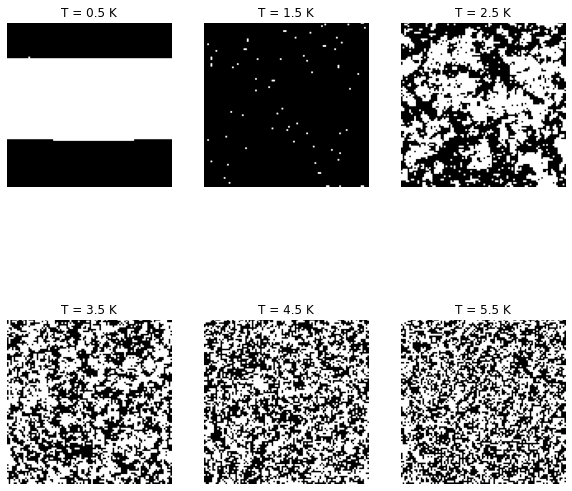

In [165]:
figure, axis = plt.subplots(2, 3, figsize = (10,10))

#Plotting the last lattice for different temperatures
for T, ax in zip(temperatures, axis.flatten()):
    
    lattice = init_lattice(N)
    lattice_evolution = run_ising(lattice, N, steps, T)
    
    ax.imshow(lattice_evolution[-1], cmap = 'Greys', vmin = -1, vmax = 1)
    ax.set_axis_off()
    ax.set_title('T = ' + str(T) + ' K')

We see that for lower temperatures (< 2.5 K) all particles tend to have the same spin, 1 or -1. We can see some **clusters** of particles with the same spin, but in the limit of steps going to infinity, the lattice will end up in a configuration of **all spins up or downs**. Around 2.5 K, we find some clusters of spin +1 and -1 particles but we never reach a stable configuration. Finally, for greater temperatures, the lattice tends to a configuration where every particle has a completely **random spin**, regardless of the initial configuration. So, we conclude that around 2.5 K the model shows a **phase transition**. 

So far, we've studied the Ising Model in a qualitative way. We would like to compute some characteristics magnitudes of the system to have a deeper understanding of what's going on. For example:

* **Average magnetization**:  $$ m_{N}=\left\langle\frac{1}{N^{2}}\left|\sum_{i=1}^{N} \sum_{j=1}^{N} s(i, j)\right|\right\rangle  \tag{3} $$

* **Average energy**: $$e_{N}=\frac{\langle E(S)\rangle}{N^2} \tag{4} $$

* **Specific heat**: $$C_{N}=\frac{1}{T^2}\left[\left\langle E(S)^{2}\right\rangle-\langle E(S)\rangle^{2}\right] = \frac{1}{T^2} \sigma ^2 _{E} \tag{5}$$

The average, $\left\langle · \right\rangle$, can be taken over every iteration of the "metropolis_step" function.

In [166]:
from scipy.ndimage import convolve, generate_binary_structure

In [167]:
def energy(lattice):
    
    #Efficient way to compute the NN sum
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    
    return arr.sum()
    

In [168]:
def ising_magnitudes(lattice_evol, N, T):
    
    avg_m, avg_e, c_heat = 0, 0, np.zeros(0)
    length = len(lattice_evol)
    
    for lattice in lattice_evol:
        
        #Average magnetization
        avg_m += lattice.sum()/(N**2)
        
        #Average energy
        e = energy(lattice)
        avg_e += e
        
        #Specific heat
        c_heat = np.append(c_heat, e)
    
    return avg_m/length, avg_e/(length*N**2), c_heat.std()/(T**2)

In [169]:
#We change lattice size to reduce computational time 
N = 50
steps = 500

temp = np.linspace(0.1, 6.1, 30)

avg_magn, avg_energy, specific_heat = np.zeros(len(temp)), np.zeros(len(temp)), np.zeros(len(temp))

i = 0
for T in temp:
    
    lattice = init_lattice(N, [1,0]) #All spins up initially
    lattice_evol =  run_ising(lattice, N, steps, T)
    avg_magn[i], avg_energy[i], specific_heat[i] = ising_magnitudes(np.array(lattice_evol), N, T)
    
    i += 1    

In [170]:
import matplotlib.pyplot as plt

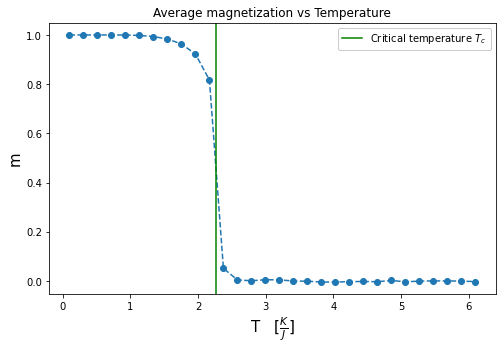

In [171]:
#Average magnetization

plt.figure(figsize=(8,5))
plt.plot(temp, avg_magn, 'o--')
plt.xlabel(r'T   [$\frac{K}{J}]$', fontsize=15)
plt.ylabel('m', fontsize=15)
plt.axvline(x=2.27, c = 'g',  label = 'Critical temperature $T_{c}$')    #Critical temperature
plt.title('Average magnetization vs Temperature')

plt.legend(facecolor='white', framealpha=1)
plt.show()

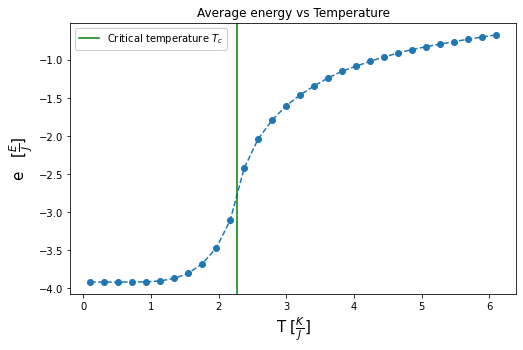

In [172]:
#Average energy

plt.figure(figsize=(8,5))
plt.plot(temp, avg_energy, 'o--')
plt.xlabel(r'T [$\frac{K}{J}]$', fontsize=15)
plt.ylabel(r'e   [$\frac{E}{J}]$', fontsize=15)
plt.axvline(x=2.27, c = 'g',  label = 'Critical temperature $T_{c}$')    #Critical temperature
plt.title('Average energy vs Temperature')

plt.legend(facecolor='white', framealpha=1)
plt.show()

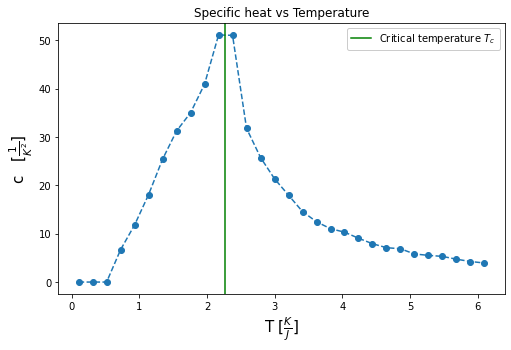

In [173]:
#Specific heat

plt.figure(figsize=(8,5))
plt.plot(temp, specific_heat, 'o--')
plt.xlabel(r'T [$\frac{K}{J}]$', fontsize=15)
plt.ylabel(r'c   [$\frac{1}{K^{2}}]$', fontsize=15)
plt.axvline(x=2.27, c = 'g',  label = 'Critical temperature $T_{c}$')    #Critical temperature
plt.title('Specific heat vs Temperature')

plt.legend(facecolor='white', framealpha=1)
plt.show()

We can see clearly that around a temperature of 2.27 the system suffers a phase trnasition. 